In [ ]:
!pip install easyocr

import easyocr
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
class SimpleTextReader:
    def __init__(self, languages=['en']):
        """
        languages: list bahasa yang ingin dideteksi
        ['en', 'id'] untuk Inggris dan Indonesia
        """
        self.reader = easyocr.Reader(languages)

    def read_from_upload(self):
        print("Upload gambar")
        uploaded = files.upload()
        file_name = list(uploaded.keys())[0]

        print("\nMembaca teks dari gambar...")
        return self.process_image(file_name)

    def process_image(self, image_path):
        """
        Proses gambar dan deteksi teks
        """
        image = cv2.imread(image_path)
        results = self.reader.readtext(image)

        output = image.copy()
        texts = []

        for bbox, text, conf in results:
            texts.append({
                'text': text,
                'confidence': conf
            })

            bbox = np.array(bbox, dtype=np.int32)
            cv2.polylines(output, [bbox], True, (0, 255, 0), 2)
            cv2.putText(output,
                       f"{text} ({conf:.2f})",
                       tuple(bbox[0]),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.8, (255, 0, 0), 2)

        plt.figure(figsize=(15,15))
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        print("\nTeks yang ditemukan:")
        print("--------------------")
        for i, item in enumerate(texts, 1):
            print(f"{item['text']}")
            print(f"   Confidence: {item['confidence']:.2f}")
            print()

        return texts

In [ ]:
def main():
    reader = SimpleTextReader(['en', 'id'])

    texts = reader.read_from_upload()

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteUpload gambar


Saving WhatsApp Image 2024-11-24 at 02.22.30_9926ad1a.jpg to WhatsApp Image 2024-11-24 at 02.22.30_9926ad1a.jpg

Membaca teks dari gambar...


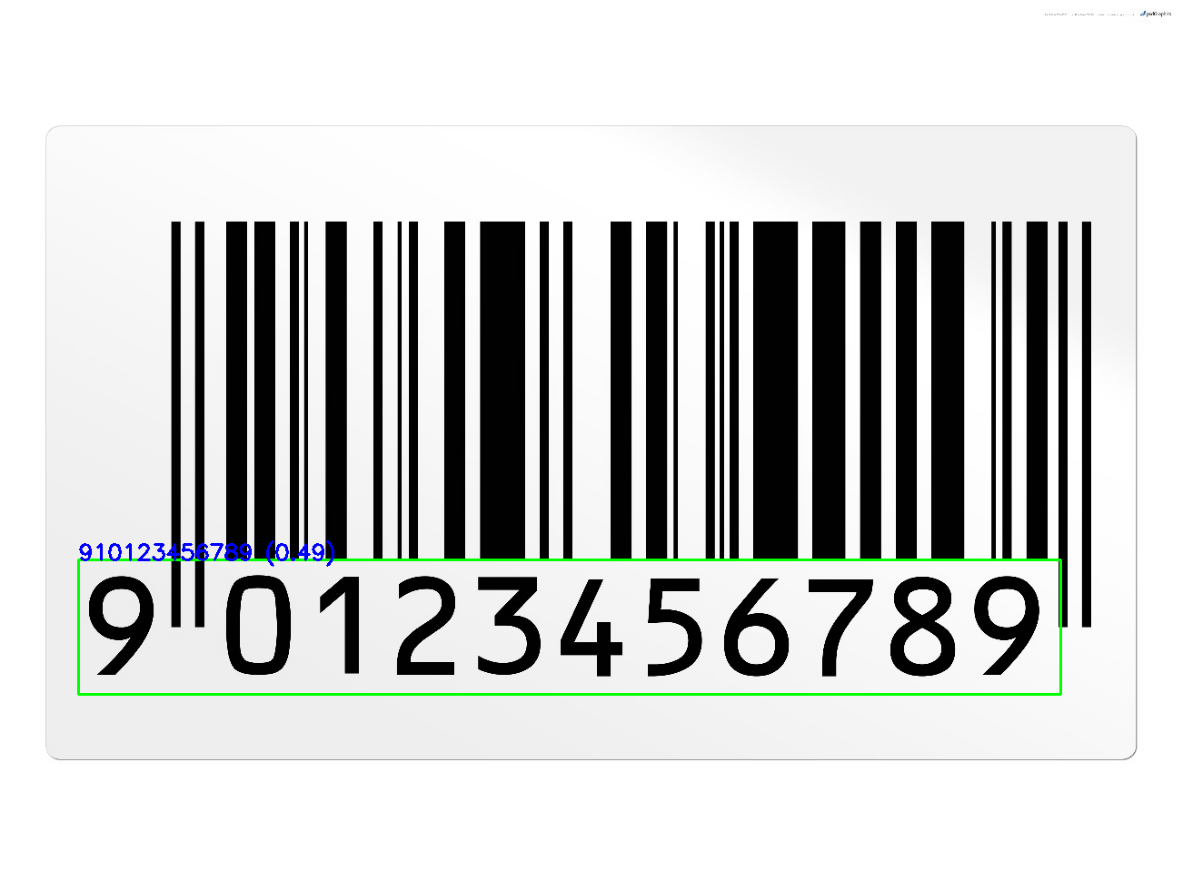


Teks yang ditemukan:
--------------------
910123456789
   Confidence: 0.49



In [ ]:
if __name__ == "__main__":
    main()

Upload gambar


Saving WhatsApp Image 2024-11-24 at 01.50.47_056eff39.jpg to WhatsApp Image 2024-11-24 at 01.50.47_056eff39 (4).jpg

Membaca teks dari gambar...


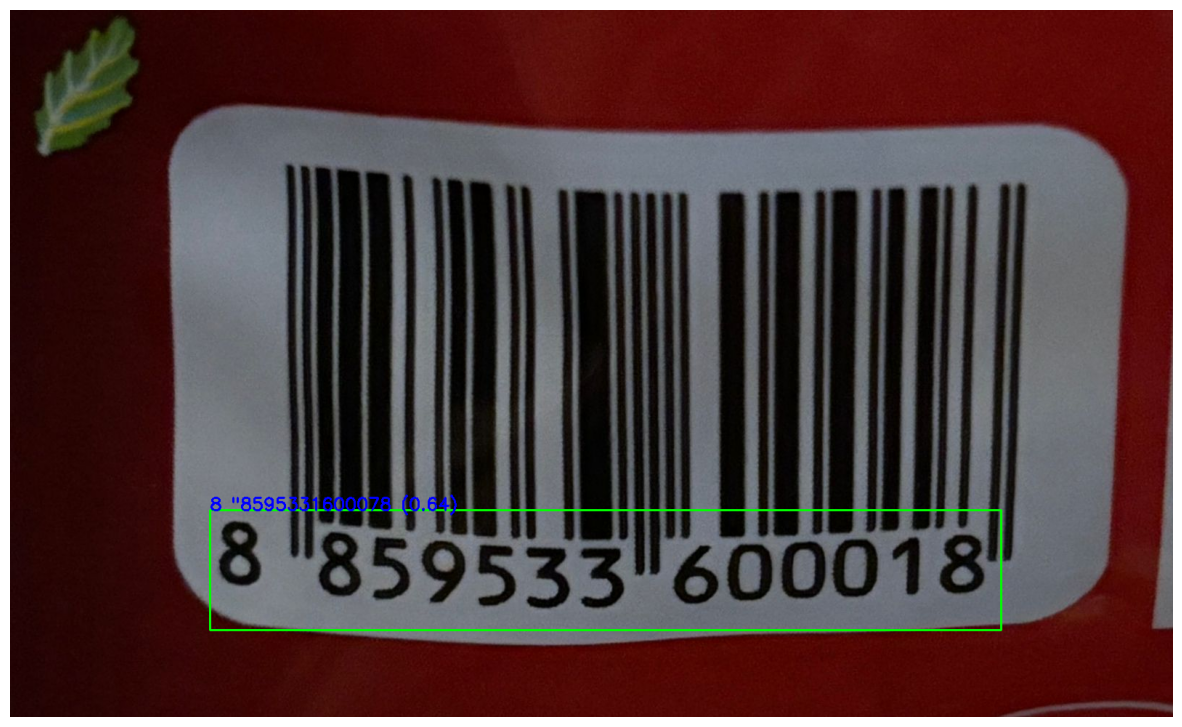


Teks yang ditemukan:
--------------------
8 "8595331600078
   Confidence: 0.64



In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
#@title MULAI DARI SINI
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract easyocr parsel Pillow numpy pandas opencv-python matplotlib

import pytesseract
import easyocr
import parsel
import numpy as np
import pandas as pd
import re
import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,452 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,223 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-securit

In [ ]:
def parse_xml(xml):
    """
    parse xml text to be accessed through xpath
    :param xml: xml text
    :type xml: str
    :return: parsel.selector.Selector
    :rtype: object
    """
    # setup xml parser
    parsel.Selector.__str__ = parsel.Selector.extract
    parsel.Selector.__repr__ = parsel.Selector.__str__
    parsel.SelectorList.__repr__ = lambda x: '[{}]'.format(
        '\n '.join("({}) {!r}".format(i, repr(s))
                   for i, s in enumerate(x, start=1))
    ).replace(r'\n', '\n')

    doc = parsel.Selector(text=xml)
    return doc

def tesseract_read(file):
    """
    extract text from the image using Tesseract
    :param file: path or image object
    :type file: str or PIL.Image
    :return: text
    :rtype: str
    """
    hocr = pytesseract.image_to_pdf_or_hocr(file, extension='hocr')
    xml = hocr.decode('utf-8')
    doc = parse_xml(xml)
    tsa_output = []

    for tag in doc.xpath('/html/body/div/div/p/span/span'):
        tsa_output.append(str(tag.xpath('text()')[0]))

    tsa_output = " ".join(tsa_output).lower()
    tsa_output = tsa_output.replace('-', ' ')

    return tsa_output

def easyocr_read(file, reader):
    """
    extract text from the image using EasyOCR
    :param file: path or image object
    :type file: str or PIL.Image
    :param reader: easyocr reader
    :type reader: easyocr.Reader
    :return: text
    :rtype: str
    """
    results = reader.readtext(file)
    results = sorted(results, key=lambda x: x[0][0])
    text_results = [x[-2] for x in results]
    easy_output = " ".join(text_results)
    easy_output = easy_output.strip()
    easy_output = re.sub('\s{2,}', ' ', easy_output)

    return easy_output

def compare_ocr(image_path):
    """
    Compare OCR results between Tesseract and EasyOCR for a single image
    :param image_path: path to the image
    :type image_path: str
    :return: dict with results
    :rtype: dict
    """
    reader = easyocr.Reader(['en'], gpu=True)
    img = Image.open(image_path)

    tsa_start_time = time.time()
    tsa_result = tesseract_read(img)
    tsa_end_time = time.time()
    tsa_time_used = (tsa_end_time - tsa_start_time)

    easy_start_time = time.time()
    easy_result = easyocr_read(img, reader)
    easy_end_time = time.time()
    easy_time_used = (easy_end_time - easy_start_time)

    return {
        'tesseract_result': tsa_result,
        'tesseract_time': tsa_time_used,
        'easyocr_result': easy_result,
        'easyocr_time': easy_time_used
    }

In [ ]:
if __name__ == '__main__':
    print("Upload an image file:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nProcessing image: {filename}")
        results = compare_ocr(filename)

        print("\nResults:")
        print(f"Tesseract result: {results['tesseract_result']}")
        print(f"EasyOCR result: {results['easyocr_result']}")

Upload an image file:


Saving OIP (1).jpeg to OIP (1).jpeg
Saving download (2).jpeg to download (2).jpeg
Saving WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f.jpg to WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f.jpg
Saving WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99.jpg to WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99.jpg
Saving download (1).jpeg to download (1).jpeg
Saving WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34.jpg to WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34.jpg

Processing image: OIP (1).jpeg
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Results:
Tesseract result:  
EasyOCR result: 66

Processing image: download (2).jpeg

Results:
Tesseract result: a, ee)    rd
EasyOCR result: 8 783981" '305449'

Processing image: WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f.jpg

Results:
Tesseract result:              ea a ie meeee sy"                     bel:   
EasyOCR result: 8 "8595331600018

Processing image: WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99.jpg

Results:
Tesseract result: 973043"580010
EasyOCR result: 6197304311580010

Processing image: download (1).jpeg

Results:
Tesseract result: 14112146152919
EasyOCR result: 11112140153919

Processing image: WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34.jpg

Results:
Tesseract result: paper fsc* c011102 muta cyl sly at associated attel. © and yt as noted. dah office ndar muda         93134 87961 ml co
EasyOCR result: 8 8 87961"93134 2 5882 2822 A la 8 0 3 9 8 8 3


In [ ]:
#@title OCR FIX
# Install required dependencies
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract easyocr parsel Pillow numpy pandas opencv-python

import pytesseract
import easyocr
import parsel
import numpy as np
import pandas as pd
import re
import time
import cv2
from PIL import Image
from google.colab import files

def preprocess_barcode_image(image):
    """
    Preprocess image to improve barcode number recognition
    :param image: PIL Image object
    :return: preprocessed PIL Image object
    """
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((1, 3), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    return Image.fromarray(dilated)

def parse_xml(xml):
    """
    parse xml text to be accessed through xpath
    :param xml: xml text
    :type xml: str
    :return: parsel.selector.Selector
    :rtype: object
    """
    parsel.Selector.__str__ = parsel.Selector.extract
    parsel.Selector.__repr__ = parsel.Selector.__str__
    parsel.SelectorList.__repr__ = lambda x: '[{}]'.format(
        '\n '.join("({}) {!r}".format(i, repr(s))
                   for i, s in enumerate(x, start=1))
    ).replace(r'\n', '\n')

    doc = parsel.Selector(text=xml)
    return doc

def clean_barcode_text(text):
    """
    Clean recognized text to extract only numbers
    :param text: recognized text
    :return: cleaned text containing only numbers
    """
    numbers_only = ''.join(filter(str.isdigit, text))
    return numbers_only

def tesseract_read(image):
    """
    extract text from the image using Tesseract
    :param image: PIL Image object
    :return: text
    :rtype: str
    """
    processed_image = preprocess_barcode_image(image)
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'

    text = pytesseract.image_to_string(processed_image, config=custom_config)
    return clean_barcode_text(text)

def easyocr_read(image, reader):
    """
    extract text from the image using EasyOCR
    :param image: PIL Image object
    :param reader: easyocr reader
    :return: text
    :rtype: str
    """
    processed_image = preprocess_barcode_image(image)
    img_array = np.array(processed_image)

    results = reader.readtext(img_array)
    text_results = [x[-2] for x in results]
    text = " ".join(text_results)
    return clean_barcode_text(text)

def compare_ocr(image_path):
    """
    Compare OCR results between Tesseract and EasyOCR for a barcode image
    :param image_path: path to the image
    :return: dict with results
    """
    reader = easyocr.Reader(['en'], gpu=True)
    img = Image.open(image_path)

    tsa_start_time = time.time()
    tsa_result = tesseract_read(img)
    tsa_end_time = time.time()
    tsa_time_used = (tsa_end_time - tsa_start_time)

    easy_start_time = time.time()
    easy_result = easyocr_read(img, reader)
    easy_end_time = time.time()
    easy_time_used = (easy_end_time - easy_start_time)

    return {
        'tesseract_result': tsa_result,
        'tesseract_time': tsa_time_used,
        'easyocr_result': easy_result,
        'easyocr_time': easy_time_used
    }

if __name__ == '__main__':
    print("Upload barcode image:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nProcessing barcode image: {filename}")
        results = compare_ocr(filename)

        print("\nResults:")
        print(f"Tesseract result: {results['tesseract_result']}")
        print(f"Tesseract time: {results['tesseract_time']:.2f} seconds")
        print(f"EasyOCR result: {results['easyocr_result']}")
        print(f"EasyOCR time: {results['easyocr_time']:.2f} seconds")

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

Saving WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34.jpg to WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34 (2).jpg

Processing barcode image: WhatsApp Image 2024-11-24 at 01.38.32_2c2bbb34 (2).jpg

Results:
Tesseract result: 
Tesseract time: 0.27 seconds
EasyOCR result: 8796193134
EasyOCR time: 0.21 seconds


In [ ]:
# Install required dependencies
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract easyocr opencv-python-headless scikit-image matplotlib numpy pandas

import pytesseract
import easyocr
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image
from google.colab import files
import time

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:3 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:

def analyze_spacing(image):
    """
    Analyze spacing between digits in barcode image
    :param image: numpy array of image
    :return: mask of valid digits
    """
    # Get image dimensions
    height, width = image.shape

    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes and filter small contours
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 5 and h > 10 and w < width * 0.9:  # Filter small and very wide contours
            boxes.append((x, y, w, h))

    # Sort boxes by x coordinate
    boxes.sort(key=lambda x: x[0])

    # Create mask for valid digits
    mask = np.zeros_like(image)

    if len(boxes) > 1:
        # Calculate distances between boxes
        distances = []
        for i in range(len(boxes)-1):
            current_box = boxes[i]
            next_box = boxes[i+1]
            distance = next_box[0] - (current_box[0] + current_box[2])
            distances.append(distance)

        # Calculate median distance
        median_distance = np.median(distances)

        # Add first box
        x, y, w, h = boxes[0]
        mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]

        # Add subsequent boxes based on distance
        for i in range(len(distances)):
            if distances[i] < median_distance * 2:  # If distance is less than 2x median
                x, y, w, h = boxes[i+1]
                mask[y:y+h, x:x+w] = image[y:y+h, x:x+w]

    return mask

def preprocess_barcode_image(image):
    """
    Preprocess image to improve barcode number recognition
    :param image: PIL Image object
    :return: preprocessed PIL Image object
    """
    # Convert PIL Image to cv2 format
    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations
    kernel = np.ones((1, 3), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    # Analyze spacing and create mask
    mask = analyze_spacing(dilated)

    return Image.fromarray(mask)

def clean_barcode_text(text):
    """
    Clean recognized text to extract only numbers
    :param text: recognized text
    :return: cleaned text containing only numbers
    """
    # Remove all non-numeric characters
    numbers_only = ''.join(filter(str.isdigit, text))
    return numbers_only

def tesseract_read(image):
    """
    Extract text from the image using Tesseract
    :param image: PIL Image object
    :return: text
    """
    # Preprocess image
    processed_image = preprocess_barcode_image(image)

    # Configure Tesseract
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'

    # Get text
    text = pytesseract.image_to_string(processed_image, config=custom_config)
    return clean_barcode_text(text)

def easyocr_read(image, reader):
    """
    Extract text from the image using EasyOCR
    :param image: PIL Image object
    :param reader: easyocr reader
    :return: text
    """
    # Preprocess image
    processed_image = preprocess_barcode_image(image)

    # Convert to numpy array
    img_array = np.array(processed_image)

    # Read text
    results = reader.readtext(img_array)
    text_results = [x[-2] for x in results]
    text = " ".join(text_results)
    return clean_barcode_text(text)

def compare_ocr(image_path):
    """
    Compare OCR results between Tesseract and EasyOCR for a barcode image
    :param image_path: path to the image
    :return: dict with results
    """
    # Initialize EasyOCR
    reader = easyocr.Reader(['en'], gpu=True)

    # Read image
    img = Image.open(image_path)

    # Get results from Tesseract
    tsa_start_time = time.time()
    tsa_result = tesseract_read(img)
    tsa_end_time = time.time()
    tsa_time_used = (tsa_end_time - tsa_start_time)

    # Get results from EasyOCR
    easy_start_time = time.time()
    easy_result = easyocr_read(img, reader)
    easy_end_time = time.time()
    easy_time_used = (easy_end_time - easy_start_time)

    return {
        'tesseract_result': tsa_result,
        'tesseract_time': tsa_time_used,
        'easyocr_result': easy_result,
        'easyocr_time': easy_time_used
    }

# Example usage
print("Upload barcode image:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nProcessing barcode image: {filename}")
    results = compare_ocr(filename)

    print("\nResults:")
    print(f"Tesseract result: {results['tesseract_result']}")
    print(f"Tesseract time: {results['tesseract_time']:.2f} seconds")
    print(f"EasyOCR result: {results['easyocr_result']}")
    print(f"EasyOCR time: {results['easyocr_time']:.2f} seconds")

Upload barcode image:


Saving barcode.jpg to barcode (2).jpg
Saving WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f.jpg to WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f (2).jpg
Saving WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99.jpg to WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99 (2).jpg

Processing barcode image: barcode (2).jpg



Results:
Tesseract result: 
Tesseract time: 0.95 seconds
EasyOCR result: 
EasyOCR time: 80.41 seconds

Processing barcode image: WhatsApp Image 2024-11-24 at 01.50.47_87eaf36f (2).jpg



Results:
Tesseract result: 
Tesseract time: 0.33 seconds
EasyOCR result: 
EasyOCR time: 25.50 seconds

Processing barcode image: WhatsApp Image 2024-11-24 at 01.46.50_49ee5b99 (2).jpg

Results:
Tesseract result: 
Tesseract time: 0.13 seconds
EasyOCR result: 
EasyOCR time: 3.39 seconds
